# Hugging Face의 transformers 모듈을 이용한 Fine Tunning.

Hugging Face의

* `transformers` 라이브러리를 사용하여
* 사전 훈련된 ViT(Vision Transformer) 모델을
* CIFAR-10 데이터셋에 파인튜닝하고 평가하는 과정을 다룸

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
import torch
from torch.utils.data import random_split, DataLoader
import time

In [2]:
from psutil import cpu_count

print(f'{type(cpu_count)=}')
print(f'{cpu_count()=}')

type(cpu_count)=<class 'function'>
cpu_count()=2


In [3]:
# device 설정.
device = (
      "cuda" if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu"
  )
print(f"{device=}")

device='cuda'


In [4]:
my_root_path = "/content/cifar10"                                            # data 저장 위치.
my_model_repo = "/content/drive/MyDrive/Classroom/AI Programming/pretrained" # model 저장 위치.

In [5]:
transform_size = 32 #224

In [6]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((transform_size, transform_size)),  # ViT 입력 크기
    # transforms.ToTensor(),
])

train_set = CIFAR10(
    root=my_root_path, train=True, download=True,
    # transform=transform,
    )
test_set  = CIFAR10(
    root=my_root_path, train=False, download=True,
    # transform=transform,
    )


100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


In [7]:
dir(train_set)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_is_protocol',
 '_load_meta',
 '_repr_indent',
 'base_folder',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'filename',
 'meta',
 'root',
 'target_transform',
 'targets',
 'test_list',
 'tgz_md5',
 'train',
 'train_list',
 'transform',
 'transforms',
 'url']

In [8]:
train_set[0] # tuple 로서 다음과 같이 PIL.Image.Image 객체와 int 라벨값을 가짐.

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [9]:
# validation set 나누기
train_size = int(0.8 * len(train_set))
validation_size = len(train_set) - train_size
train_set, validation_set = random_split(
    train_set, [train_size, validation_size]
)

# Subset에서는 classes와 class_to_idx 가 없으므로 다시 설정.
train_set.classes = test_set.classes
train_set.class_to_idx = test_set.class_to_idx
validation_set.classes = test_set.classes
validation_set.class_to_idx = test_set.class_to_idx

In [11]:
print(f'{type(transforms)      = }')
print(f'{type(train_set)       = }')
print(f'{type(validation_set)  = }')
# print(f"{train_set.root      = }") # 열면 에러
print(f"{test_set.classes      = }")
print(f"{test_set.class_to_idx = }")

type(transforms)      = <class 'module'>
type(train_set)       = <class 'torch.utils.data.dataset.Subset'>
type(validation_set)  = <class 'torch.utils.data.dataset.Subset'>
test_set.classes      = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
test_set.class_to_idx = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


# transformers 관련 모듈 import

* 이미지 전처리: `AutoImageProcessor`가 이를 담담함.
* 사전 훈련된 모델: `AutoModelForImageClassification`을 통해 얻을 수 있음.

특정 정해진 문자열로 `AutoImageProcessor`와 `AutoModelForImageClassification`을 통해 사전훈련시 사용된 똑같은 이미지 처리와 사전 훈련된 모델을 얻을 수 있음.



In [12]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

checkpoint = "google/vit-base-patch16-224-in21k"


`google/vit-base-patch16-224-in21k` :

Google에서 개발한 Vision Transformer(ViT) 모델의 사전 훈련된 **check point** 임.

* `google`: 모델을 개발하고 제공한 주체(Google Research)를 의미.
* `vit-base`: Vision Transformer 의 기본 크기 모델(Base)임을 의미.
  * ViT 모델은 다음의 크기로 나뉨.
  * `Base`, `Large`, `Huge`
* `patch16`: 이미지를 16x16 픽셀 크기의 패치로 분할하여 처리한다는 의미.
  * 이미지는 먼저 작은 패치들로 나뉘고,
  * 이 패치들이 Transformer 모델의 입력 시퀀스로 사용됨.
* `224`: 모델이 훈련될 때 사용된 입력 이미지의 해상도가 224x224 픽셀임을 의미.
  * 해상도가 다른 이미지 사용시 전처리 필요.
* `in21k`: 모델이 사전 훈련될 때 사용된 데이터셋을 의미.
  * `in21k`는 ImageNet-21k 데이터셋을 의미
  * ImageNet-1k보다 훨씬 많은 21,000개 이상의 클래스와 1,400만 개 이상의 이미지를 포함하는 대규모 이미지 데이터셋을 의미함.
  * 이 데이터셋으로 사전 훈련된 모델은 다양한 이미지 분류 작업에 대한 일반화 성능이 뛰어난 경향이 있음.

1. 지정된 checkpoint 에 해당하는 사전 훈련된 설정을 로드.
  * 처음에 ImageNet-21k 데이터셋으로 원래 ViT 모델을 훈련하는 데 사용된 설정을 로드.
2. CIFAR-10 데이터셋의 요구 사항 (10개 클래스, 32x32 이미지)에 맞게 조정.

In [13]:
# Position Embedding Interpolation을 통한 해상도 차이 처리.

# 추론 성능이 조금 문제가 있을 수 있으나, 처리속도는 빠름.

# 설정 수정
from transformers import ViTConfig
config = ViTConfig.from_pretrained(checkpoint)
config.image_size = 32  # CIFAR-10 크기로 변경
config.num_labels = 10  # CIFAR-10은 10개 클래스
config.id2label = {i: c for i, c in enumerate(train_set.classes)}
config.label2id={c: i for i, c in enumerate(train_set.classes)},

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

## ImageProcessor

`transformers` 를 이용하는 경우, 이미지 전처리를 담당하는 클래스.

`AutoImageProcessor.from_pretrained(checkpoint:str)`

위의 코드로 얻어냄.

각 checkpoint에 해당하는 ImageProcessor객체가 얻어지며, 이는 사전훈련시 사용된 전처리를 가능하게 해 줌.

snapshot 디렉토리 밑의 랜덤한 이름의 디렉토리에 다음의 주요 파일이 다운로드됨.
* `preprocessor_config.json`:
  * 이미지 전처리에 필요한 설정 파일.
  * 이 파일에는 이미지 크기, 정규화 방법 등 전처리기가 작동하는 데 필요한 정보가 있음.
* `config.json`:
  * 모델 자체의 설정 파일.
  * 모델의 구조, 레이어 정보, 학습 시 사용된 파라미터 등 모델 아키텍처에 대한 정보가 있음.


In [14]:
!rm -rf "/content/vit_cache"

In [15]:
from transformers import ViTConfig
config = ViTConfig.from_pretrained(checkpoint)
config.image_size = (32,32)  # CIFAR-10 크기로 변경
config.num_labels = 10  # CIFAR-10은 10개 클래스
config.id2label = {i: c for i, c in enumerate(train_set.classes)}
config.label2id={c: i for i, c in enumerate(train_set.classes)},

image_processor = AutoImageProcessor.from_pretrained(
    checkpoint,
    config = config,
    size={"height": transform_size, "width": transform_size},
    cache_dir="/content/vit_cache", # optional
    use_fast=True,                  # 기본은 느린 버전임(호환성 높음)
)
# # transformers.models.vit.image_processing_vit.ViTImageProcessor
# type(image_processor)

# 이미지 크기 확인
print("Image size:", config.image_size)
print("Image size:", image_processor.size)
print("Type:", type(image_processor.size))

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Image size: (32, 32)
Image size: {'height': 32, 'width': 32}
Type: <class 'dict'>


Hugging Face에서 비공개 모델 및 데이터셋 접근할 경우 Token 설정이 필요함.

우리의 경우 공개 모델을 이용하므로 필요없음.

# ImageProcessor를 통한 Vit모델이 기대하는 데이터 구조 만들기.

`ImageProcessor`는 사전 훈련 시 사용된 이미지 전처리 과정을 수행하는 클래스임.

transformers 라이브러리의 많은 이미지 처리 관련 사전 훈련 모델들은 파인튜닝이나 추론을 위해 특정 데이터 구조를 입력으로 기대함.

이 데이터 구조는 보통 batch당 dict 객체로 반환되며 `"pixel_values"`와 `"labels"` 라는 두가지 필수키로 구성됨.

* `"pixel_values"`:
  * ImageProcessor에 의해 전처리된 이미지 데이터
  * PyTorch 또는 TensorFlow 등의 텐서 형태.
* `"labels"`:
  * 이미지에 해당하는 라벨 데이터
  * PyTorch 또는 TensorFlow 등의 텐서 형태.
  * 이 키는 주로 모델을 학습시킬 때 손실 계산을 위해 필요하며, 추론 시에는 필수가 아님.

여기서는 `collate_fn`을 통해 반환하는 `inputs` 객체는 다음과 같은 주요 키들을 포함하도록 구현함

In [16]:
def collate_fn(batch):
  # image들로 구성된 imgs와 int라벨로 구성된 labels를
  # 각각 list로 만들어냄.
  imgs, labels = zip(*batch)

  # image_processor는
  # PIL.Image 의 list or torch.Tensor를 args.로 받음.
  intputs = image_processor(
      list(imgs),
      return_tensors="pt", #PyTorch의 텐서로 변환을 지시함.
  )
  # image_processor는 반드시
  # "labels" 키에 라벨정보를 가진 tensor객체를 가져야함.
  intputs["labels"] = torch.tensor(labels)
  return intputs

# batch 인자는
# DataLoader가 데이터를 반복할 때
# 데이터셋에서 반환하는 개별 데이터 샘플들의 list임.
# 다음은 2개의 instance로 구성되는 batch를 가정한 테스트임.
inputs = collate_fn([train_set[0], train_set[1]])

In [17]:
# 전처리된 이미지의 텐서 형태 출력
print(f"{inputs['pixel_values'].shape = }")
# 전처리된 이미지의 데이터 타입 출력
print(f"{inputs['pixel_values'].dtype = }")
# 전처리된 이미지의 최소값 출력
print(f"{inputs['pixel_values'].min() = }")
# 전처리된 이미지의 최대값 출력
print(f"{inputs['pixel_values'].max() = }")

inputs['pixel_values'].shape = torch.Size([2, 3, 32, 32])
inputs['pixel_values'].dtype = torch.float32
inputs['pixel_values'].min() = tensor(-0.9137)
inputs['pixel_values'].max() = tensor(1.)


# 사전훈련된 모델 객체 얻기.

In [18]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    # num_labels=10,  # CIFAR-10은 10개 클래스. config 사용시 주석처리해야함.
    # id2label={i: c for i, c in enumerate(train_set.classes)},
    # label2id={c: i for i, c in enumerate(train_set.classes)},
    cache_dir="/content/vit_cache",
    # Position embedding이 자동으로 보간됨
    # 32×32 이미지 → 2×2 = 4개 패치 (16×16 패치 크기)
    config=config,
    ignore_mismatched_sizes=True, # 이미지 크기 불일치 무시하여 동작하도록
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# feature extractor(encoder) freeze
for param in model.vit.parameters():
    param.requires_grad = False

# classifier head만 학습됨
for param in model.classifier.parameters():
    param.requires_grad = True


In [20]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


vit.embeddings.cls_token: requires_grad = False
vit.embeddings.position_embeddings: requires_grad = False
vit.embeddings.patch_embeddings.projection.weight: requires_grad = False
vit.embeddings.patch_embeddings.projection.bias: requires_grad = False
vit.encoder.layer.0.attention.attention.query.weight: requires_grad = False
vit.encoder.layer.0.attention.attention.query.bias: requires_grad = False
vit.encoder.layer.0.attention.attention.key.weight: requires_grad = False
vit.encoder.layer.0.attention.attention.key.bias: requires_grad = False
vit.encoder.layer.0.attention.attention.value.weight: requires_grad = False
vit.encoder.layer.0.attention.attention.value.bias: requires_grad = False
vit.encoder.layer.0.attention.output.dense.weight: requires_grad = False
vit.encoder.layer.0.attention.output.dense.bias: requires_grad = False
vit.encoder.layer.0.intermediate.dense.weight: requires_grad = False
vit.encoder.layer.0.intermediate.dense.bias: requires_grad = False
vit.encoder.layer.0.outp

In [21]:
def print_freeze_status(model, indent=0, recurse=False):
    for name, module in model.named_children():
        # 해당 모듈이 파라미터를 가진다면 freeze 여부 출력
        has_params = False
        for param in module.parameters(recurse=False):
            print('  ' * indent + f"{name}: requires_grad = {param.requires_grad}")
            has_params = True
        # 만약 파라미터가 없다면, 하위 모듈로 내려감
        if not has_params:
            print('  ' * indent + f"{name}: (no parameters)")
        if recurse:
          print_freeze_status(module, indent + 1)

print_freeze_status(model)


vit: (no parameters)
classifier: requires_grad = True
classifier: requires_grad = True


In [22]:
batch_size = 32
n_worker = 1

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    pin_memory = True,
    collate_fn = collate_fn,
    num_workers = n_worker,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = batch_size,
    shuffle = False,
    pin_memory = True,
    collate_fn = collate_fn,
    num_workers = n_worker,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = collate_fn,
    num_workers = n_worker,
)

In [23]:
# 로드된 데이터 확인 (첫 번째 배치만 확인)
batch = next(iter(train_loader))

In [24]:
batch.keys()

dict_keys(['pixel_values', 'labels'])

In [25]:
batch['pixel_values'].shape

torch.Size([32, 3, 32, 32])

type(grid_img)=<class 'torch.Tensor'>
max_val.item()=1.0
min_val.item()=-1.0


(np.float64(-0.5), np.float64(273.5), np.float64(137.5), np.float64(-0.5))

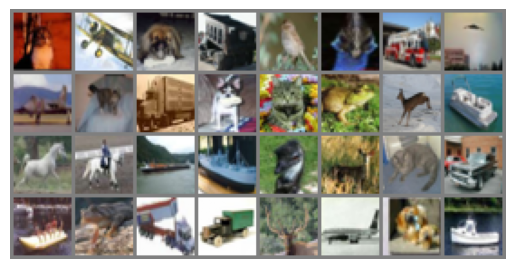

In [26]:
dataiter = iter(train_loader)
batch = next(dataiter)

grid_img = torchvision.utils.make_grid(batch['pixel_values'])
max_val = torch.max(grid_img)
min_val = torch.min(grid_img)
print(f'{type(grid_img)=}\n{max_val.item()=}\n{min_val.item()=}')

normalized_grid_img = (grid_img - min_val) / (max_val - min_val)
plt.imshow(np.transpose(normalized_grid_img, (1,2,0)))
plt.axis('off')

In [27]:
import torch
import time
import copy
from typing import Optional, Tuple, Dict, Any
from tqdm import tqdm


def train_loop(
    n_epoch: int,                                   # 총 훈련할 epoch 수 (전체 데이터셋을 몇 번 반복할지)
    train_loader: torch.utils.data.DataLoader,      # 훈련 데이터를 배치 단위로 제공하는 DataLoader
    val_loader: torch.utils.data.DataLoader,        # 검증 데이터를 배치 단위로 제공하는 DataLoader
    model: torch.nn.Module,                         # 훈련할 신경망 모델 (nn.Module을 상속받은 클래스)
    optimizer: torch.optim.Optimizer,               # 가중치 업데이트를 담당하는 옵티마이저 (SGD, Adam 등)
    # loss_fnc: torch.nn.Module,                      # 손실함수 (MSELoss, CrossEntropyLoss 등)
    device: str = 'cpu',                            # 연산을 수행할 디바이스 ('cpu' 또는 'cuda')
    print_every: int = 5,                           # 몇 epoch마다 진행상황을 출력할지 결정
    early_stop_patience: Optional[int] = None,      # Early stopping: 몇 epoch 동안 개선이 없으면 중단할지
    save_best_model: bool = True,                   # 최고 성능의 모델 가중치를 저장할지 여부
    verbose: bool = True,                           # 상세한 출력을 할지 여부 (False면 조용히 훈련)
) -> Tuple[torch.nn.Module, torch.Tensor, Optional[torch.nn.Module]]:
    """
    개선된 PyTorch 훈련 루프

    이 함수는 딥러닝 모델의 전체 훈련 과정을 관리함.

    훈련은 다음과 같은 단계로 진행됩니다:
    1. 모델을 훈련 모드로 설정
    2. 훈련 데이터로 순전파(forward pass) 수행
    3. 손실 계산
    4. 역전파(backward pass)로 그래디언트 계산
    5. 옵티마이저로 가중치 업데이트
    6. 검증 데이터로 모델 성능 평가
    7. 로그 기록 및 조기 종료 조건 확인

    Args:
        n_epoch:             총 훈련 epoch 수 (한 epoch = 전체 훈련 데이터를 한 번 모두 보는 것)
        train_loader:        훈련 데이터 로더 (배치 크기만큼 데이터를 자동으로 제공)
        val_loader:          검증 데이터 로더 (모델의 일반화 성능을 측정하기 위함)
        model:               훈련할 모델 (신경망의 구조와 가중치를 포함)
        optimizer:           옵티마이저 (그래디언트를 이용해 가중치를 어떻게 업데이트할지 결정)
        loss_fnc:            손실 함수 (모델의 예측과 실제 정답 간의 차이를 수치화)
        device:              연산 디바이스 (GPU 사용시 훈련 속도가 크게 향상됨)
        print_every:         로그 출력 간격 (너무 자주 출력하면 성능에 영향)
        early_stop_patience: 조기 종료 기준 (과적합 방지 및 훈련 시간 절약)
        save_best_model:     최고 성능 모델 저장 (검증 손실이 가장 낮았던 시점의 모델)
        verbose:             상세 출력 여부 (디버깅이나 모니터링 시 유용)

    Returns:
        tuple containing:
        - 훈련이 완료된 모델 (마지막 epoch의 가중치)
        - 로그 히스토리 텐서 (각 epoch의 훈련/검증 손실 기록)
        - 최고 성능 모델 (검증 손실이 가장 낮았던 모델, save_best_model=True일 때만)
    """

    # =================================================================
    # 1단계: 초기 설정 및 변수 초기화
    # =================================================================

    # 모델을 지정된 디바이스(CPU 또는 GPU)로 이동
    # 이는 모든 연산이 같은 디바이스에서 수행되도록 보장함
    # GPU와 CPU 간 데이터 이동은 오버헤드가 크므로 한 번에 이동
    model = model.to(device)

    # 훈련 과정의 손실값들을 기록할 리스트 초기화
    # 각 원소는 [epoch 번호, 훈련 손실, 검증 손실] 형태
    # 리스트로 시작했다가 나중에 텐서로 변환 (동적 크기 관리 편의성)
    log_hist = []

    # Early stopping 관련 변수들 초기화
    # Early stopping은 검증 손실이 더 이상 개선되지 않을 때 훈련을 중단하는 기법
    best_val_loss    = float('inf')   # 지금까지 가장 좋은(낮은) 검증 손실값
    best_model       = None           # 최고 성능을 보인 모델의 가중치 저장용
    patience_counter = 0              # 성능 개선이 없었던 연속 epoch 수 카운터

    # 전체 훈련 시작 시간 기록 (총 훈련 소요 시간 측정용)
    total_start_time = time.time()

    # 사용자가 요청한 경우 훈련 시작 메시지 출력
    if verbose:
        print(f"훈련 시작: {n_epoch} epoch, 디바이스: {device}")
        print("-" * 60)  # 구분선으로 가독성 향상


    # =================================================================
    # 2단계: 메인 훈련 루프 시작
    # =================================================================

    try:  # 예외 처리를 위한 try 블록 시작

        # epoch 루프: 전체 데이터셋을 n_epoch번 반복하여 학습
        for epoch in range(n_epoch):

            # 각 epoch의 시작 시간 기록 (epoch당 소요 시간 측정용)
            epoch_start_time = time.time()

            # =============================================================
            # 2-1단계: 훈련(Training) 단계
            # =============================================================

            # 모델을 train 모드로 설정
            # 훈련 모드에서는 Dropout, BatchNorm 등이 훈련용으로 동작
            # - Dropout:   일부 뉴런을 무작위로 비활성화하여 과적합 방지
            # - BatchNorm: 배치별 정규화를 수행하고 학습 가능한 파라미터 업데이트
            model.train()

            # 한 epoch 동안의 훈련 손실 누적용 변수들
            train_loss_sum    = 0.0        # 모든 배치의 손실값 합계
            train_batch_count = 0         # 처리한 배치 수 (평균 계산용)

            # 훈련 데이터 로더에서 배치별로 데이터 가져오기
            # train_loader는 (입력 데이터, 정답 레이블) 튜플을 배치 크기만큼 제공
            for batch_idx, batch in enumerate(tqdm(train_loader)):

                # # 배치 데이터를 지정된 디바이스로 이동
                # # non_blocking=True: GPU 메모리 복사를 비동기적으로 수행하여 성능 향상 시도.
                # # 단, 이는 고정된(pinned) 메모리에서만 효과적인 점 주의할 것.
                # x_tensor = x_tensor.to(device, non_blocking=True)  # 입력 데이터
                # y_tensor = y_tensor.to(device, non_blocking=True)  # 정답 레이블

                inputs = {k: v.to(device, non_blocking=True) for k,v in batch.items()}
                outputs = model(**inputs)
                loss_train = outputs.loss

                # # 순전파(Forward Pass): 모델에 입력을 넣어 예측값 계산
                # # 이 과정에서 모든 레이어를 통과하며 최종 출력 생성
                # y_pred = model(x_tensor)

                # # 손실 계산: 예측값과 실제값 간의 차이를 수치화
                # # 손실 함수의 종류에 따라 계산 방식이 달라짐
                # # - 회귀: MSE, MAE 등 (연속값 예측)
                # # - 분류: CrossEntropy, NLL 등 (카테고리 예측)
                # if not loss_fnc:
                #   loss_train = loss_fnc(y_pred, y_tensor)
                # else:
                #   loss_train = y_pred.loss

                # 손실값 이상치 검사
                # 무한대나 NaN 값은 훈련이 불안정해졌음을 의미
                # 이런 경우 즉시 훈련을 중단하여 시간 낭비 방지
                if torch.isinf(loss_train) or torch.isnan(loss_train):
                    raise ValueError(f"epoch {epoch}, 배치 {batch_idx}에서 비정상적인 손실 발생: {loss_train.item()}")

                # 역전파(Backward Pass) 준비: 이전 그래디언트 초기화
                # PyTorch는 그래디언트를 누적하므로 매 배치마다 초기화 필요
                # 이를 하지 않으면 이전 배치의 그래디언트가 계속 쌓임
                optimizer.zero_grad()

                # 역전파 수행: 손실에 대한 각 파라미터의 그래디언트 계산
                # 연쇄법칙(chain rule)을 이용해 출력층부터 입력층까지 그래디언트 전파
                loss_train.backward()

                # 가중치 업데이트: 계산된 그래디언트를 이용해 모델 파라미터 조정
                # 옵티마이저의 종류(SGD, Adam 등)에 따라 업데이트 방식이 달라짐
                # - SGD: weight = weight - learning_rate * gradient
                # - Adam: 모멘텀과 적응적 학습률을 함께 사용
                optimizer.step()

                # 현재 배치의 손실값을 전체 합계에 누적
                # .item()은 텐서에서 파이썬 스칼라 값을 추출 (메모리 효율성)
                train_loss_sum += loss_train.item()
                train_batch_count += 1
            # end for train


            # 한 epoch의 평균 훈련 손실 계산
            # 배치별 손실의 평균을 구해 epoch 전체의 대표값으로 사용
            avg_train_loss = train_loss_sum / train_batch_count

            # =============================================================
            # 2-2단계: 검증(Validation) 단계
            # =============================================================

            # 모델을 평가 모드로 설정
            # 평가 모드에서는 Dropout이 비활성화되고 BatchNorm이 추론용으로 동작
            # - Dropout:   모든 뉴런을 활성화 (무작위 제거 없음)
            # - BatchNorm: 훈련 중 학습된 통계량(평균, 분산)을 사용
            model.eval()

            # 검증 단계 손실 누적용 변수들
            val_loss_sum    = 0.0        # 모든 검증 배치의 손실값 합계
            val_batch_count = 0          # 처리한 검증 배치 수

            # 그래디언트 계산 비활성화: 검증 시에는 가중치 업데이트가 불필요
            # 메모리 사용량 감소 및 연산 속도 향상 효과
            # autograd 엔진이 연산 그래프를 생성하지 않음
            with torch.no_grad():

                # 검증 데이터 로더에서 배치별로 데이터 가져오기
                # for x_tensor, y_tensor in tqdm(val_loader):
                for batch in tqdm(val_loader):

                    # 검증 데이터도 같은 디바이스로 이동
                    # x_tensor = x_tensor.to(device, non_blocking=True)
                    # y_tensor = y_tensor.to(device, non_blocking=True)
                    inputs = {k: v.to(device, non_blocking=True) for k,v in batch.items()}
                    outputs = model(**inputs)
                    loss_val = outputs.loss

                    # # 순전파만 수행 (역전파 없음)
                    # # 현재 모델 가중치로 예측값 계산
                    # y_pred = model(x_tensor)

                    # # 검증 손실 계산 (훈련과 동일한 손실 함수 사용)
                    # loss_val = loss_fnc(y_pred, y_tensor)

                    # 검증 손실 누적 (평균 계산을 위함)
                    val_loss_sum += loss_val.item()
                    val_batch_count += 1

            # 한 에포크의 평균 검증 손실 계산
            # 이 값이 모델의 일반화 성능을 나타내는 지표
            avg_val_loss = val_loss_sum / val_batch_count

            # =============================================================
            # 2-3단계: 로그 기록 및 성능 추적
            # =============================================================

            # 현재 에포크의 결과를 히스토리에 추가
            # [에포크 번호, 평균 훈련 손실, 평균 검증 손실] 형태로 저장
            log_hist.append([epoch, avg_train_loss, avg_val_loss])

            # =============================================================
            # 2-4단계: 최고 성능 모델 관리 (Early Stopping 포함)
            # =============================================================

            # 최고 성능 모델 저장이 활성화된 경우
            if save_best_model and avg_val_loss < best_val_loss:
                print("save_best_model!")

                # 새로운 최고 성능 달성
                best_val_loss = avg_val_loss

                # 현재 모델의 가중치를 깊은 복사로 저장
                # deepcopy를 사용하여 원본과 완전히 독립적인 복사본 생성
                # state_dict()는 모델의 모든 학습 가능한 파라미터를 딕셔너리로 반환
                best_model = copy.deepcopy(model.state_dict())

                # patience 카운터 리셋 (성능이 개선되었으므로)
                patience_counter = 0

                # 최고 성능 달성 알림 (verbose이고 출력 시점인 경우에만)
                if verbose and epoch % print_every == 0:
                    print("    → 새로운 최고 성능 모델 저장!")

            else:
                # 성능 개선이 없는 경우 patience 카운터 증가
                # Early stopping을 위한 카운터
                patience_counter += 1

            # =============================================================
            # 2-5단계: 진행상황 출력 및 모니터링
            # =============================================================

            # 지정된 간격마다 또는 마지막 에포크에서 진행상황 출력
            print('001')
            if verbose and (epoch % print_every == 0 or epoch == n_epoch - 1):

                # 현재 에포크 소요 시간 계산
                epoch_time = time.time() - epoch_start_time

                # 총 훈련 소요 시간 계산
                total_time = time.time() - total_start_time

                # 상세한 진행상황 출력
                # 에포크 번호, 시간 정보, 손실값들을 한 줄로 표시
                print(f"에포크 {epoch:4d}/{n_epoch-1} | "                   # 에포크 진행상황
                      f"시간: {epoch_time:.2f}s (총 {total_time:.1f}s) | "   # 시간 정보
                      f"훈련 손실: {avg_train_loss:.6f} | "                  # 훈련 성능
                      f"검증 손실: {avg_val_loss:.6f}")                      # 일반화 성능


            # =============================================================
            # 2-6단계: Early Stopping 조건 확인
            # =============================================================

            # Early stopping이 활성화되어 있고 patience를 초과한 경우
            print('002')
            if early_stop_patience is not None and patience_counter >= early_stop_patience:

                if verbose:
                    print(f"\nEarly stopping 발동! {early_stop_patience} 에포크 동안 성능 향상 없음")
                    print(f"최고 검증 손실: {best_val_loss:.6f}")

                # 훈련 루프 중단 (break는 for문만 빠져나감)
                break
        # end epoch

    # =================================================================
    # 3단계: 예외 처리 및 훈련 완료 처리
    # =================================================================

    # 사용자가 Ctrl+C로 훈련을 중단한 경우
    except KeyboardInterrupt:
        if verbose:
            print("\n\n훈련이 사용자에 의해 중단되었습니다.")

    # 기타 예외 발생 시 (메모리 부족, 모델 오류 등)
    except Exception as e:
        print(f"\n\n훈련 중 오류 발생: {str(e)}")
        raise  # 예외를 다시 발생시켜 호출자가 처리할 수 있도록 함

    # =================================================================
    # 4단계: 훈련 완료 후 정리 및 결과 반환
    # =================================================================

    # 전체 훈련 소요 시간 계산
    total_training_time = time.time() - total_start_time

    # 훈련 완료 메시지 출력
    if verbose:
        print("-" * 60)  # 구분선
        print(f"훈련 완료! 총 소요시간: {total_training_time:.1f}초")

        # 최고 성능 모델이 저장된 경우 그 정보도 출력
        if save_best_model and best_model is not None:
            print(f"최고 검증 손실: {best_val_loss:.6f}")

    # 로그 히스토리를 파이썬 리스트에서 PyTorch 텐서로 변환
    # 텐서로 변환하면 GPU 연산, 슬라이싱, 수학 연산 등이 용이해짐
    log_hist_tensor = torch.tensor(log_hist, device=device)

    # 최고 성능 모델 복원 준비
    final_best_model = None
    if save_best_model and best_model is not None:

        # 새로운 모델 인스턴스 생성 (원본 모델과 독립적)
        final_best_model = copy.deepcopy(model)

        # 저장된 최고 성능 가중치를 새 모델에 로드
        # load_state_dict()는 저장된 파라미터를 모델에 복원
        final_best_model.load_state_dict(best_model)

    # 결과 반환: (현재 모델, 훈련 히스토리, 최고 성능 모델)
    # 현재 모델: 마지막 에포크의 가중치를 가진 모델
    # 훈련 히스토리: 전체 훈련 과정의 손실값 기록
    # 최고 성능 모델: 검증 손실이 가장 낮았던 시점의 모델
    return model, log_hist_tensor, final_best_model

In [28]:
# number of epochs
n_epoch = 31
# learning ratio
lr = 2e-4

# optimizer 생성 및 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # recommanded

# 경사하강법(SGD) 옵티마이저로, 모델 파라미터의 업데이트를 수행한다.
# net.parameters() : 모델의 학습 가능한 파라미터들을 반환.
# lr : learning rate(학습률)을 나타낸다.
# momentum : 관성을 나타내며, 학습의 안정성과 수렴 속도를 높이는데 도움을 준다.
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

trained_model, history, best_model = train_loop(
    n_epoch=n_epoch,                # 최대 11 에포크까지 훈련 (early stopping으로 더 일찍 끝날 수 있음)
    train_loader=train_loader,
    val_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    # loss_fnc=loss_fnc,
    device=device,
    early_stop_patience=20,         # 2 에포크 동안 성능 향상이 없으면 중단
    print_every=1,                  # 1 에포크마다 진행상황 출력
    save_best_model=True,           # 최고 성능 모델 저장 (메모리임)
    verbose=True                    # 상세한 출력 활성화
)

훈련 시작: 31 epoch, 디바이스: cuda
------------------------------------------------------------


100%|██████████| 313/313 [00:04<00:00, 63.61it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    0/30 | 시간: 32.83s (총 32.8s) | 훈련 손실: 2.055872 | 검증 손실: 1.879165
002


100%|██████████| 313/313 [00:05<00:00, 62.09it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    1/30 | 시간: 24.31s (총 57.1s) | 훈련 손실: 1.804403 | 검증 손실: 1.728140
002


100%|██████████| 313/313 [00:05<00:00, 60.56it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    2/30 | 시간: 24.51s (총 81.7s) | 훈련 손실: 1.691398 | 검증 손실: 1.648560
002


100%|██████████| 313/313 [00:05<00:00, 61.91it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    3/30 | 시간: 24.55s (총 106.2s) | 훈련 손실: 1.624963 | 검증 손실: 1.597999
002


100%|██████████| 313/313 [00:11<00:00, 26.67it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    4/30 | 시간: 31.59s (총 137.8s) | 훈련 손실: 1.579949 | 검증 손실: 1.564016
002


100%|██████████| 313/313 [00:04<00:00, 65.61it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    5/30 | 시간: 25.37s (총 163.2s) | 훈련 손실: 1.546922 | 검증 손실: 1.538890
002


100%|██████████| 313/313 [00:04<00:00, 63.52it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    6/30 | 시간: 25.42s (총 188.6s) | 훈련 손실: 1.521295 | 검증 손실: 1.520002
002


100%|██████████| 313/313 [00:05<00:00, 59.65it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    7/30 | 시간: 26.52s (총 215.1s) | 훈련 손실: 1.501035 | 검증 손실: 1.504164
002


100%|██████████| 313/313 [00:05<00:00, 59.70it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    8/30 | 시간: 25.41s (총 240.5s) | 훈련 손실: 1.483956 | 검증 손실: 1.490317
002


100%|██████████| 313/313 [00:05<00:00, 58.80it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크    9/30 | 시간: 25.46s (총 266.0s) | 훈련 손실: 1.469671 | 검증 손실: 1.481153
002


100%|██████████| 313/313 [00:05<00:00, 60.18it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   10/30 | 시간: 25.41s (총 291.4s) | 훈련 손실: 1.457405 | 검증 손실: 1.471554
002


100%|██████████| 313/313 [00:04<00:00, 63.37it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   11/30 | 시간: 25.21s (총 316.6s) | 훈련 손실: 1.446798 | 검증 손실: 1.463739
002


100%|██████████| 313/313 [00:04<00:00, 65.82it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   12/30 | 시간: 25.14s (총 341.7s) | 훈련 손실: 1.437282 | 검증 손실: 1.458856
002


100%|██████████| 313/313 [00:04<00:00, 67.34it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   13/30 | 시간: 25.99s (총 367.7s) | 훈련 손실: 1.428772 | 검증 손실: 1.452688
002


100%|██████████| 313/313 [00:04<00:00, 67.20it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   14/30 | 시간: 25.10s (총 392.8s) | 훈련 손실: 1.421441 | 검증 손실: 1.447257
002


100%|██████████| 313/313 [00:04<00:00, 66.91it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   15/30 | 시간: 25.41s (총 418.2s) | 훈련 손실: 1.414552 | 검증 손실: 1.444097
002


100%|██████████| 313/313 [00:04<00:00, 66.51it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   16/30 | 시간: 25.25s (총 443.5s) | 훈련 손실: 1.408199 | 검증 손실: 1.439460
002


100%|██████████| 313/313 [00:04<00:00, 67.32it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   17/30 | 시간: 25.15s (총 468.6s) | 훈련 손실: 1.402760 | 검증 손실: 1.436152
002


100%|██████████| 313/313 [00:04<00:00, 67.06it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   18/30 | 시간: 25.12s (총 493.8s) | 훈련 손실: 1.397544 | 검증 손실: 1.433154
002


100%|██████████| 313/313 [00:05<00:00, 60.11it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   19/30 | 시간: 25.86s (총 519.6s) | 훈련 손실: 1.392883 | 검증 손실: 1.430152
002


100%|██████████| 313/313 [00:05<00:00, 61.33it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   20/30 | 시간: 25.39s (총 545.0s) | 훈련 손실: 1.388349 | 검증 손실: 1.427435
002


100%|██████████| 313/313 [00:05<00:00, 61.09it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   21/30 | 시간: 25.17s (총 570.2s) | 훈련 손실: 1.384282 | 검증 손실: 1.425804
002


100%|██████████| 313/313 [00:05<00:00, 59.96it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   22/30 | 시간: 25.09s (총 595.3s) | 훈련 손실: 1.380506 | 검증 손실: 1.423750
002


100%|██████████| 313/313 [00:05<00:00, 60.34it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   23/30 | 시간: 25.16s (총 620.4s) | 훈련 손실: 1.377019 | 검증 손실: 1.423032
002


100%|██████████| 313/313 [00:05<00:00, 60.76it/s]


001
에포크   24/30 | 시간: 25.35s (총 645.8s) | 훈련 손실: 1.373544 | 검증 손실: 1.423755
002


100%|██████████| 313/313 [00:05<00:00, 60.01it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   25/30 | 시간: 25.22s (총 671.0s) | 훈련 손실: 1.370629 | 검증 손실: 1.419924
002


100%|██████████| 313/313 [00:05<00:00, 62.31it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   26/30 | 시간: 25.80s (총 696.8s) | 훈련 손실: 1.367656 | 검증 손실: 1.418614
002


100%|██████████| 313/313 [00:04<00:00, 64.57it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   27/30 | 시간: 25.08s (총 721.9s) | 훈련 손실: 1.364902 | 검증 손실: 1.418321
002


100%|██████████| 313/313 [00:04<00:00, 66.44it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   28/30 | 시간: 25.09s (총 747.0s) | 훈련 손실: 1.362470 | 검증 손실: 1.416386
002


100%|██████████| 313/313 [00:04<00:00, 66.98it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   29/30 | 시간: 25.26s (총 772.2s) | 훈련 손실: 1.360032 | 검증 손실: 1.414001
002


100%|██████████| 313/313 [00:04<00:00, 67.19it/s]


save_best_model!
    → 새로운 최고 성능 모델 저장!
001
에포크   30/30 | 시간: 25.17s (총 797.4s) | 훈련 손실: 1.357751 | 검증 손실: 1.413780
002
------------------------------------------------------------
훈련 완료! 총 소요시간: 797.4초
최고 검증 손실: 1.413780


In [29]:
type(best_model)

transformers.models.vit.modeling_vit.ViTForImageClassification

In [30]:
my_model_repo

'/content/drive/MyDrive/Classroom/AI Programming/pretrained'

In [31]:
# Fine-tuning 완료 후 둘 다 저장
import os.path

model_save_path = os.path.join(my_model_repo,"my-finetuned-model")

model.save_pretrained(model_save_path)
image_processor.save_pretrained(model_save_path)

['/content/drive/MyDrive/Classroom/AI Programming/pretrained/my-finetuned-model/preprocessor_config.json']

In [33]:
# 저장된 모델과 processor 불러오기
model = AutoModelForImageClassification.from_pretrained(model_save_path)
image_processor = AutoImageProcessor.from_pretrained(model_save_path)

ValueError: Argument label2id should be a dictionary.

In [34]:
model.to(device)
model.eval()  # 추론 모드로 설정

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [35]:
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

def evaluate_model(model, processor, test_loader, device):
    """전체 테스트셋에 대한 평가"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):

            inputs = {k: v.to(device, non_blocking=True) for k,v in batch.items()}
            # print(inputs)

            # 추론
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(inputs["labels"].cpu().numpy())

    return all_predictions, all_labels

# 평가 실행
predictions, true_labels = evaluate_model(model, image_processor, test_loader, device)

# 결과 계산
accuracy = accuracy_score(true_labels, predictions)
print(f"테스트 정확도: {accuracy:.4f}")

# 상세한 분류 리포트
class_names = test_set.classes
print("\n분류 리포트:")
print(classification_report(true_labels, predictions, target_names=class_names))

Evaluating: 100%|██████████| 313/313 [00:04<00:00, 62.72it/s]


테스트 정확도: 0.4965

분류 리포트:
              precision    recall  f1-score   support

    airplane       0.53      0.57      0.55      1000
  automobile       0.58      0.59      0.58      1000
        bird       0.40      0.37      0.38      1000
         cat       0.36      0.32      0.34      1000
        deer       0.48      0.44      0.46      1000
         dog       0.43      0.44      0.44      1000
        frog       0.51      0.61      0.56      1000
       horse       0.53      0.49      0.51      1000
        ship       0.56      0.57      0.56      1000
       truck       0.56      0.57      0.57      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



CIFAR-10 테스트셋에서 36개 이미지 추출 및 시각화
36개 이미지에 대해 추론 중...
  10/36 완료
  20/36 완료
  30/36 완료

선택된 36개 이미지 정확도: 0.5833


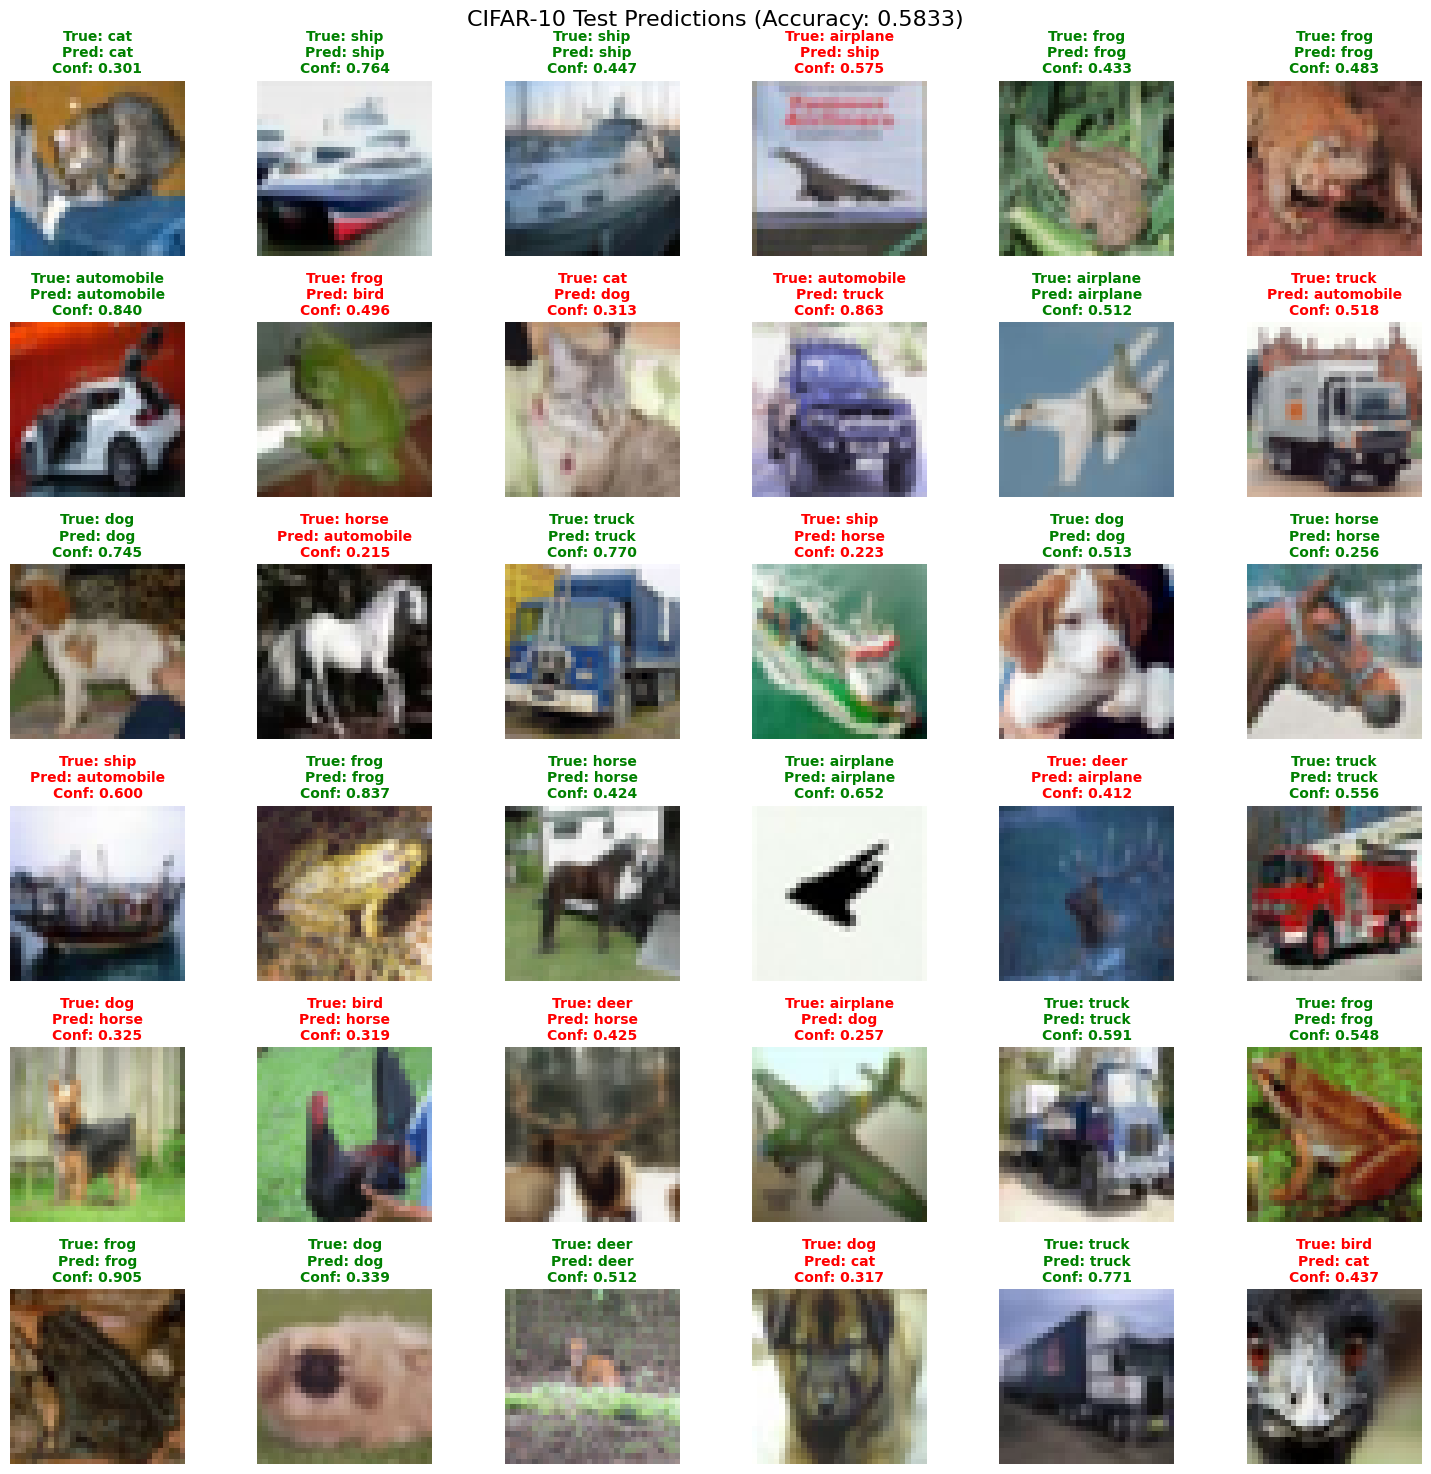


결과 요약:
- 총 이미지: 36개
- 정답: 21개
- 오답: 15개
- 평균 신뢰도: 0.514

틀린 예측들:
  이미지 3: airplane → ship (신뢰도: 0.575)
  이미지 7: frog → bird (신뢰도: 0.496)
  이미지 8: cat → dog (신뢰도: 0.313)
  이미지 9: automobile → truck (신뢰도: 0.863)
  이미지 11: truck → automobile (신뢰도: 0.518)
  이미지 13: horse → automobile (신뢰도: 0.215)
  이미지 15: ship → horse (신뢰도: 0.223)
  이미지 18: ship → automobile (신뢰도: 0.600)
  이미지 22: deer → airplane (신뢰도: 0.412)
  이미지 24: dog → horse (신뢰도: 0.325)
  이미지 25: bird → horse (신뢰도: 0.319)
  이미지 26: deer → horse (신뢰도: 0.425)
  이미지 27: airplane → dog (신뢰도: 0.257)
  이미지 33: dog → cat (신뢰도: 0.317)
  이미지 35: bird → cat (신뢰도: 0.437)


In [36]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score

def visualize_predictions_from_dataset(model, processor, test_set, num_images=36, start_idx=0):
    """테스트셋에서 직접 PIL 이미지를 추출하여 6x6 시각화"""

    # 모델을 CPU로 이동
    model = model.to('cpu')
    model.eval()

    # 테스트셋에서 36개 이미지 추출
    pil_images = []
    true_labels = []

    # CIFAR-10 데이터셋에서 PIL 이미지 추출
    for i in range(start_idx, min(start_idx + num_images, len(test_set))):
        # 데이터셋에서 이미지와 라벨 가져오기
        # transform에 ToTensor()가 없으므로 이미 PIL Image 형태
        pil_img, label = test_set[i]

        pil_images.append(pil_img)
        true_labels.append(label)

    # 각 이미지에 대해 개별 추론
    predictions = []
    confidences = []

    print(f"{len(pil_images)}개 이미지에 대해 추론 중...")

    with torch.no_grad():
        for i, pil_img in enumerate(pil_images):
            # 이미지 전처리 (이미 PIL Image이므로 바로 processor에 입력)
            inputs = processor(images=pil_img, return_tensors="pt")
            inputs = {k: v.to('cpu') for k, v in inputs.items()}

            # 추론
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

            predicted_id = torch.argmax(probabilities, dim=-1).item()
            confidence = torch.max(probabilities, dim=-1)[0].item()

            predictions.append(predicted_id)
            confidences.append(confidence)

            if (i + 1) % 10 == 0:
                print(f"  {i + 1}/{len(pil_images)} 완료")

    # 정확도 계산
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\n선택된 {len(pil_images)}개 이미지 정확도: {accuracy:.4f}")

    # 6x6 시각화
    rows = int(np.sqrt(num_images))
    cols = rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    fig.suptitle(f'CIFAR-10 Test Predictions (Accuracy: {accuracy:.4f})', fontsize=16)

    for i in range(len(pil_images)):
        row = i // cols
        col = i % cols
        ax = axes[row, col]

        # PIL 이미지 표시 (이미 224x224로 resize됨)
        ax.imshow(pil_images[i])

        # 정답과 예측 라벨
        true_label = test_set.classes[true_labels[i]]
        pred_label = test_set.classes[predictions[i]]
        confidence = confidences[i]

        # 정답과 예측이 같으면 초록색, 다르면 빨간색
        color = 'green' if true_labels[i] == predictions[i] else 'red'

        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                    fontsize=10, color=color, weight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 요약
    correct_count = sum(1 for t, p in zip(true_labels, predictions) if t == p)
    print(f"\n결과 요약:")
    print(f"- 총 이미지: {len(pil_images)}개")
    print(f"- 정답: {correct_count}개")
    print(f"- 오답: {len(pil_images) - correct_count}개")
    print(f"- 평균 신뢰도: {np.mean(confidences):.3f}")

    # 틀린 예측들 출력
    incorrect_predictions = [(i, true_labels[i], predictions[i], confidences[i])
                           for i in range(len(pil_images))
                           if true_labels[i] != predictions[i]]

    if incorrect_predictions:
        print(f"\n틀린 예측들:")
        for idx, true_id, pred_id, conf in incorrect_predictions:
            true_class = test_set.classes[true_id]
            pred_class = test_set.classes[pred_id]
            print(f"  이미지 {idx}: {true_class} → {pred_class} (신뢰도: {conf:.3f})")

    return pil_images, true_labels, predictions, confidences

# 실행 예시
print("CIFAR-10 테스트셋에서 36개 이미지 추출 및 시각화")
pil_images, true_labels, predictions, confidences = visualize_predictions_from_dataset(
    model, image_processor, test_set, num_images=36, start_idx=0
)

# 랜덤한 위치에서 시작하고 싶다면:
# import random
# random_start = random.randint(0, len(test_set) - 36)
# pil_images, true_labels, predictions, confidences = visualize_predictions_from_dataset(
#     model, image_processor, test_set, num_images=36, start_idx=random_start
# )